In [19]:
import awkward as ak
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

from coffea.nanoevents import NanoEventsFactory, BaseSchema

import scipy
from scipy import stats, optimize, interpolate

from plotWafer import plotWafer
from utils.metrics import emd

In [2]:
#!wget https://emdhgcalae.nrp-nautilus.io/pu_study/ntuple_1.root

In [3]:
signaldomain = '/ecoderemdvol/pu_study/ntuple_1.root'
signalfile = uproot.open(signaldomain)

In [4]:
decoded_events = NanoEventsFactory.from_root(
    signalfile,
    treepath='FloatingpointAElpheDummyHistomaxxydr015GenmatchGenclustersntuple/HGCalTriggerNtuple',
    #entry_stop=10,
    #metadata={"dataset": "llp"},
    schemaclass=BaseSchema,
).events()

In [5]:
input_events = NanoEventsFactory.from_root(
    signalfile,
    treepath='FloatingpointThreshold0DummyHistomaxxydr015GenmatchGenclustersntuple/HGCalTriggerNtuple',
    #entry_stop=10,
    #metadata={"dataset": "llp"},
    schemaclass=BaseSchema,
).events()

In [6]:
gen_pt = input_events.gen_pt
gen_eta = input_events.gen_eta

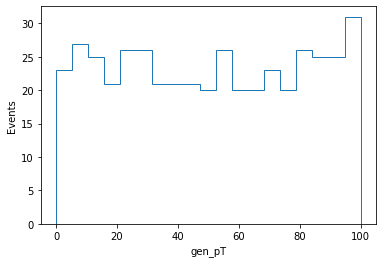

In [7]:
plt.hist(gen_pt[:,0],bins=np.linspace(0,100,20),histtype='step')
plt.xlabel('gen_pT')
plt.ylabel('Events');

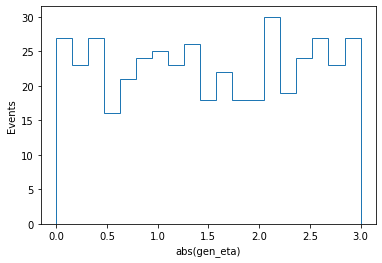

In [8]:
plt.hist(abs(gen_eta[:,0]),bins=np.linspace(0,3,20),histtype='step')
plt.xlabel('abs(gen_eta)')
plt.ylabel('Events');

### Select which events you want to look at

In [9]:
#Only look at problematic events

pt_mask = (gen_pt <=20)[:,0]
eta_min_mask = (gen_eta[:,0] >=2.6)
eta_max_mask = (gen_eta[:,0] <= 3.0)

mask = ak.Array(np.logical_and(np.asarray(pt_mask),np.asarray(eta_min_mask),np.asarray(eta_max_mask)))

In [10]:
np.count_nonzero(mask)

7

In [11]:
input_data = ak.Array(
    {
        'tc_zside': input_events['tc_zside'][mask],
        'tc_layer': input_events['tc_layer'][mask],
        'tc_waferu': input_events['tc_waferu'][mask],
        'tc_waferv': input_events['tc_waferv'][mask],
        'tc_cellu': input_events['tc_cellu'][mask],
        'tc_cellv': input_events['tc_cellv'][mask],
        'tc_data': input_events['tc_data'][mask],
        'tc_eta': input_events['tc_eta'][mask],
    }                
)

In [12]:
decoded_data = ak.Array(
    {
        'tc_zside': decoded_events['tc_zside'][mask],
        'tc_layer': decoded_events['tc_layer'][mask],
        'tc_waferu': decoded_events['tc_waferu'][mask],
        'tc_waferv': decoded_events['tc_waferv'][mask],
        'tc_cellu': decoded_events['tc_cellu'][mask],
        'tc_cellv': decoded_events['tc_cellv'][mask],
        'tc_data': decoded_events['tc_data'][mask],
        'tc_eta': decoded_events['tc_eta'][mask]
    }                
)

In [13]:
df = ak.to_pandas(input_data)
dfRemap = pd.read_csv('/ecoderemdvol/tcRemap.csv')
df = df.reset_index().merge(dfRemap)

df['ADCT'] = (df.tc_data* ((1./np.cosh(df.tc_eta))*2**12).astype(int)/2**12).astype(int)

#create new unique index (can't get pivot working on multi-indexing, but this is essentially the same)
df['WaferEntryIdx'] = (df.entry*1000000 + df.tc_layer*10000 + df.tc_waferu*100 + df.tc_waferv)*df.tc_zside

val = 'ADCT'
dfTrainData = df.pivot_table(index='WaferEntryIdx',columns='tc_cell_train',values=val).fillna(0).astype(int)
dfTrainData.columns = [f'CALQ_{i}_in' for i in range(48)]

dfTrainData[['entry','zside','layer','waferu','waferv']] = df.groupby(['WaferEntryIdx'])[['entry','tc_zside','tc_layer','tc_waferu','tc_waferv']].mean()

#dfTrainData['simenergy'] = df.groupby(['WaferEntryIdx'])[['tc_simenergy']].sum()

#Mapping wafer_u,v to physical coordinates
dfEtaPhi=pd.read_csv('/ecoderemdvol/WaferEtaPhiMap.csv')
dfTrainData=dfTrainData.merge(dfEtaPhi, on=['layer','waferu','waferv'])
dfTrainData.reset_index(drop=True,inplace=True)

ae_input = dfTrainData

/opt/conda/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1205: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  warnings.warn(


In [14]:
df = ak.to_pandas(decoded_data)
dfRemap = pd.read_csv('/ecoderemdvol/tcRemap.csv')
df = df.reset_index().merge(dfRemap)

df['ADCT'] = (df.tc_data* ((1./np.cosh(df.tc_eta))*2**12).astype(int)/2**12).astype(int)

#create new unique index (can't get pivot working on multi-indexing, but this is essentially the same)
df['WaferEntryIdx'] = (df.entry*1000000 + df.tc_layer*10000 + df.tc_waferu*100 + df.tc_waferv)*df.tc_zside

val = 'ADCT'
dfTrainData = df.pivot_table(index='WaferEntryIdx',columns='tc_cell_train',values=val).fillna(0).astype(int)
dfTrainData.columns = [f'CALQ_{i}_out' for i in range(48)]

dfTrainData[['entry','zside','layer','waferu','waferv']] = df.groupby(['WaferEntryIdx'])[['entry','tc_zside','tc_layer','tc_waferu','tc_waferv']].mean()

#dfTrainData['simenergy'] = df.groupby(['WaferEntryIdx'])[['tc_simenergy']].sum()

#Mapping wafer_u,v to physical coordinates
dfEtaPhi=pd.read_csv('/ecoderemdvol/WaferEtaPhiMap.csv')
dfTrainData=dfTrainData.merge(dfEtaPhi, on=['layer','waferu','waferv'])
dfTrainData.reset_index(drop=True,inplace=True)

ae_output = dfTrainData

In [122]:
merged = pd.merge(ae_input,ae_output,on=['tc_eta','tc_phi','layer','subdet','entry','zside'],how='outer')

### Select which wafers you want to look at

In [126]:
merged = merged[merged.tc_eta > 2.7][merged.layer<=11][merged.layer>=5]

/tmp/ipykernel_2163/1022716005.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  merged = merged[merged.tc_eta > 2.7][merged.layer<=11][merged.layer>=5]


In [127]:
CALQ_COLS_in = ['CALQ_%i_in'%c for c in range(0, 48)]
CALQ_COLS_out = ['CALQ_%i_out'%c for c in range(0, 48)]
input_Q = merged[CALQ_COLS_in]
output_Q = merged[CALQ_COLS_out]

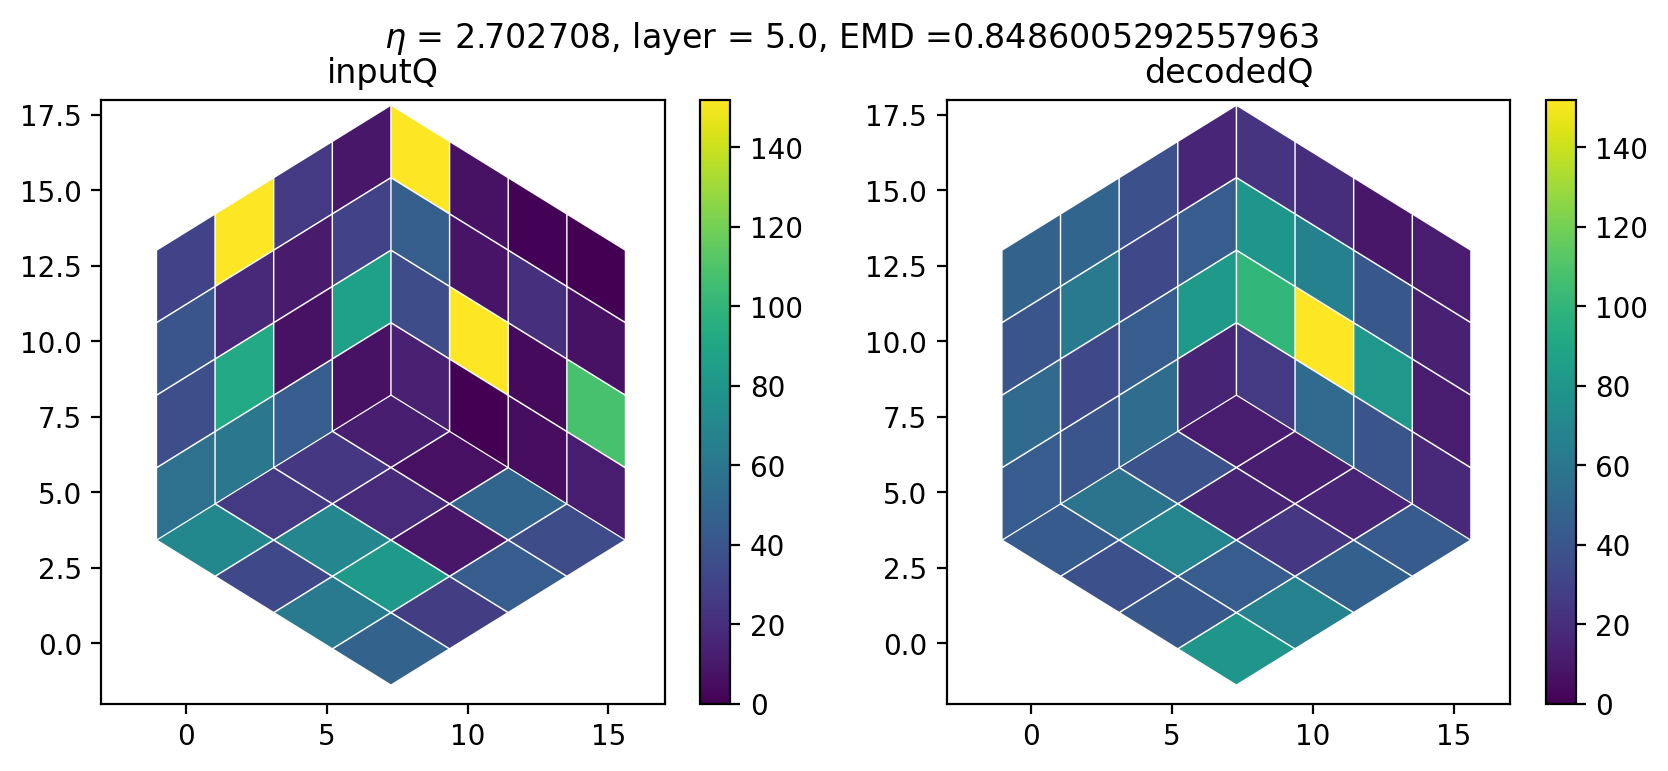

In [130]:
i = np.random.randint(1,len(merged['tc_eta']))
fig, axs = plt.subplots(1,2, figsize=(10, 4))
axs[0].set(title='inputQ')
axs[1].set(title='decodedQ')
minQ = min(min(input_Q.iloc[i]),min(input_Q.iloc[i]))
maxQ = max(max(output_Q.iloc[i]),max(output_Q.iloc[i]))
plotWafer(input_Q.iloc[i], fig, axs[0], scale=(minQ,maxQ))
plotWafer(output_Q.iloc[i], fig, axs[1], scale=(minQ,maxQ))
plt.suptitle(r'$\eta$ = {}, layer = {}, EMD ={}'.format(merged.tc_eta.iloc[i],merged.layer.iloc[i],(emd(input_Q.iloc[i],output_Q.iloc[i]))))
plt.show()

In [86]:
indices = range(len(input_Q))
event_emd = np.array([emd(input_Q.iloc[i],output_Q.iloc[j]) for i, j in zip(indices,indices)])

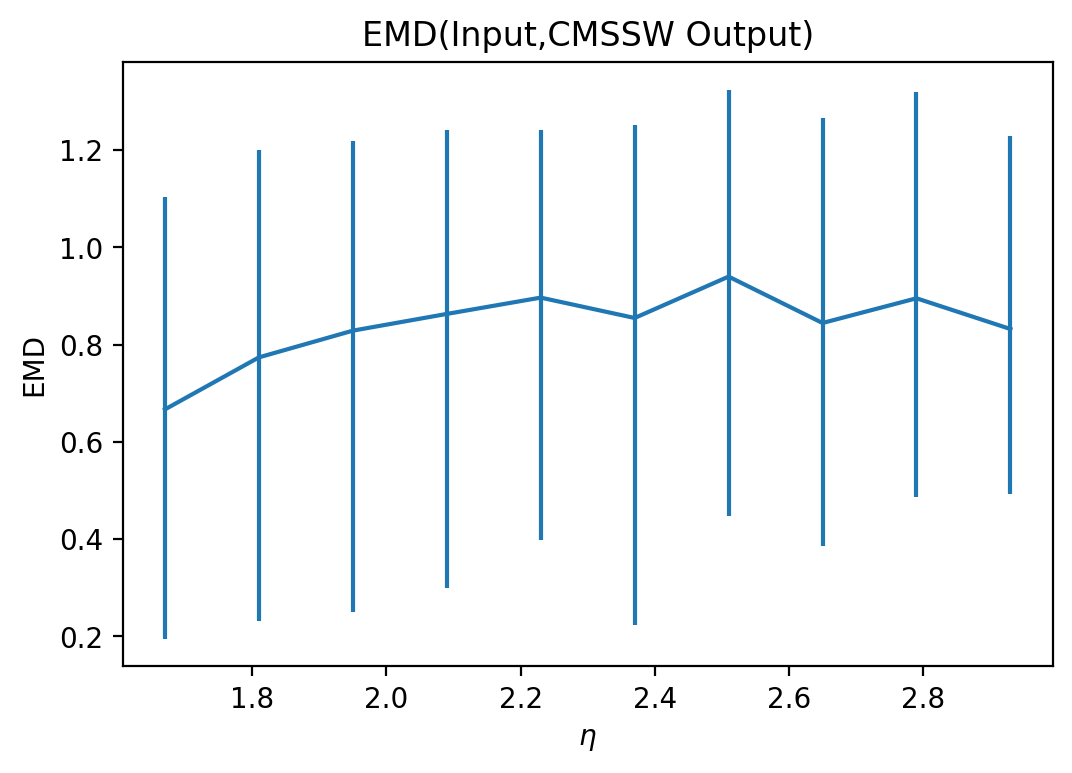

In [87]:
x = merged['tc_eta']
    
y = event_emd
        
nbins=10
stats=True
lims = (1.6,3.0)
median_result = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5))
lo_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5-0.68/2))
hi_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5+0.68/2))
median = np.nan_to_num(median_result.statistic)
hi = np.nan_to_num(hi_result.statistic)
lo = np.nan_to_num(lo_result.statistic)
hie = hi-median
loe = median-lo
bin_edges = median_result.bin_edges
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.errorbar(x=bin_centers , y=median, yerr=[loe,hie])
plt.xlabel(r'$\eta$')
plt.ylabel('EMD')
plt.title('EMD(Input,CMSSW Output)')
plt.show();

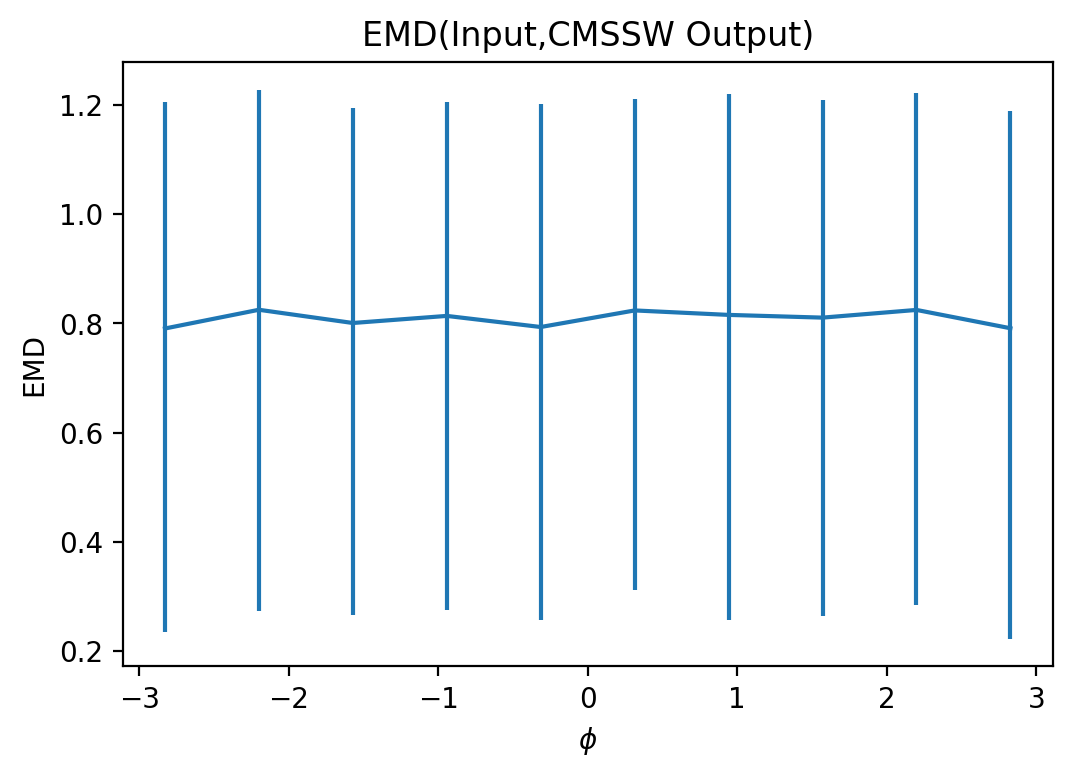

In [90]:
x = merged['tc_phi']
    
y = event_emd
        
nbins=10
stats=True
lims = (-np.pi,np.pi)
median_result = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5))
lo_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5-0.68/2))
hi_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5+0.68/2))
median = np.nan_to_num(median_result.statistic)
hi = np.nan_to_num(hi_result.statistic)
lo = np.nan_to_num(lo_result.statistic)
hie = hi-median
loe = median-lo
bin_edges = median_result.bin_edges
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.errorbar(x=bin_centers , y=median, yerr=[loe,hie])
plt.xlabel(r'$\phi$')
plt.ylabel('EMD')
plt.title('EMD(Input,CMSSW Output)')
plt.show();

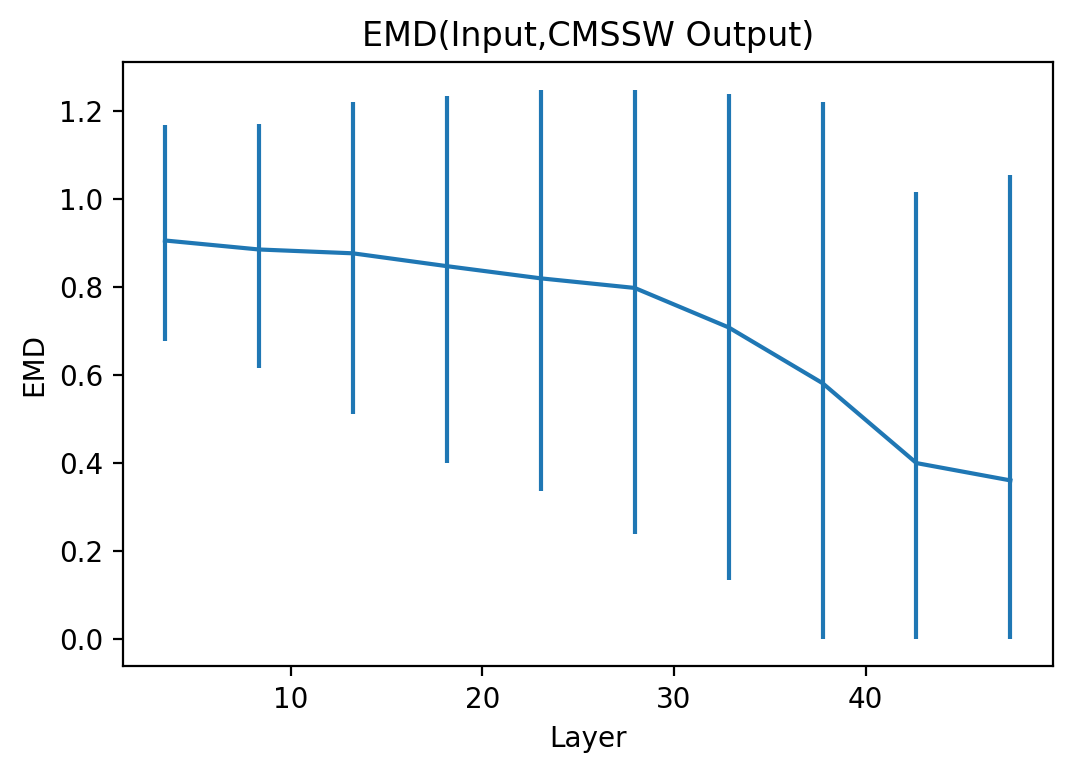

In [92]:
x = merged['layer']
    
y = event_emd
        
nbins=10
stats=True
lims = None
median_result = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5))
lo_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5-0.68/2))
hi_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5+0.68/2))
median = np.nan_to_num(median_result.statistic)
hi = np.nan_to_num(hi_result.statistic)
lo = np.nan_to_num(lo_result.statistic)
hie = hi-median
loe = median-lo
bin_edges = median_result.bin_edges
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.errorbar(x=bin_centers , y=median, yerr=[loe,hie])
plt.xlabel('Layer')
plt.ylabel('EMD')
plt.title('EMD(Input,CMSSW Output)')
plt.show();